# Monthly champagne sales millions

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('du lieu cung cap/champagne_new.xlsx', index_col=0)

In [4]:
df.head()

,monthly_champange
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [5]:
df.shape

(105, 1)

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
monthly_champange    105 non-null int64
dtypes: int64(1)
memory usage: 1.6 KB


## 1. Decomposition, trực quan hóa, nhận xét.

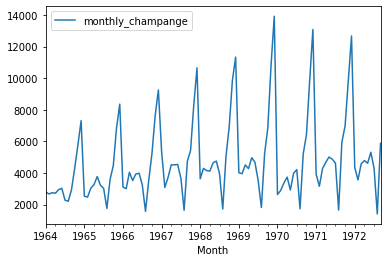

In [8]:
df.plot()

1. Dữ liệu không tuyến tính
2. Dữ liệu ghi nhận theo tháng
3. Dữ liệu thay đổi theo season
4. Giá trị thay đổi ngày càng tăng

==> sử dụng multiplicative để decompose dữ liệu

In [9]:
result = seasonal_decompose(df, model='multiplicative')

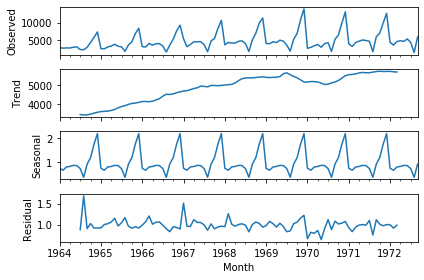

In [10]:
result.plot()
plt.show()

1. Độ biến động của dữ liệu theo thời gian ngày càng tăng.
2. Trend ban đầu có dạng tuyến tính nhưng về sau lại lên xuống không rõ ==> chọn phi tuyến
3. Dữ liệu thay đổi theo mùa cao.
4. Residual thay đổi tương đối, có một số điểm bất thường nhưng không nhiều

## 2. Tạo dữ liệu train/test với train chiếm 75% dữ liệu, test chiếm 25% dữ liệu.

In [11]:
# total line = 105
train_data = df[:80]
test_data = df[80:]

## 3. Áp dụng auto_arima để xây dựng mô hình

In [12]:
stepwise_model=auto_arima(
    df,
    start_p=1, start_q=1,
    max_p=6, max_q=6,
    m=12,
    start_P=1,
    seasonal=True,
    d=1, D=1,
    trace=True,
    error_action='ignore',  suppress_warnings=True,
    stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1486.171, BIC=1501.302, Fit time=1.385 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1526.661, BIC=1531.705, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1509.055, BIC=1519.143, Fit time=0.282 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1490.560, BIC=1500.647, Fit time=0.515 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1524.662, BIC=1527.183, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1485.185, BIC=1497.794, Fit time=1.013 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(1, 1, 1) seasona

In [13]:
stepwise_model.aic()

1484.3611700429483

In [14]:
stepwise_model.fit(train_data)

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [15]:
predict_ = stepwise_model.predict(n_periods=25)
predict_data = pd.DataFrame(predict_, index=test_data.index, columns=['predict'])

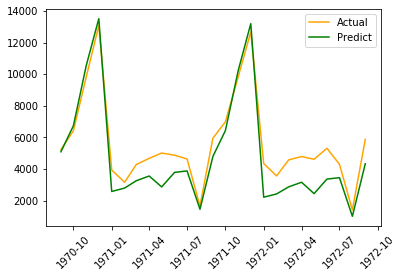

In [16]:
plt.plot(test_data, label='Actual', c='orange')
plt.plot(predict_data, label='Predict', c='g')
plt.xticks(rotation='45')
plt.legend()
plt.show()

#### Dữ liệu predict khá khớp với dữ liệu thực tế ==> model phù hợp

## 4. Dự đoán kết quả trong 9 tháng kế tiếp

In [17]:
next_9_months = stepwise_model.predict(n_periods=34)[25:]
start_time = predict_data.index[-1]
next_9_months_index = [start_time + relativedelta(months=i) for i in range(9)]
next_9_months_data = pd.DataFrame(next_9_months, index=next_9_months_index, columns=['next_9_months'])

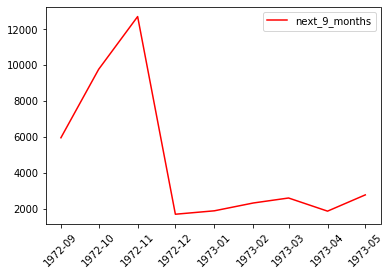

In [18]:
plt.plot(next_9_months_data, label='next_9_months', c='r')
plt.xticks(rotation='45')
plt.legend()
plt.show()

## 5. Trực quan hóa kết quả

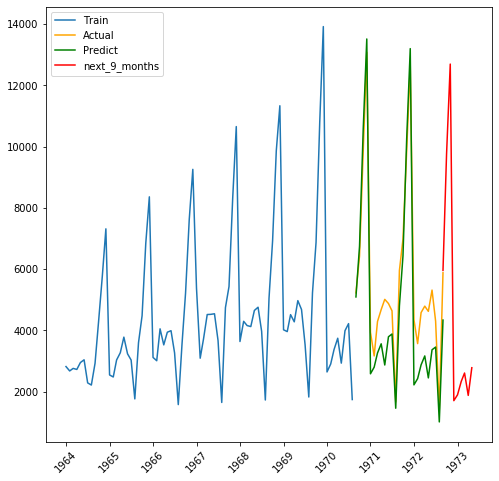

In [19]:
plt.figure(figsize=(8,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Actual', c='orange')
plt.plot(predict_data, label='Predict', c='g')
plt.plot(next_9_months_data, label='next_9_months', c='r')
plt.xticks(rotation='45')
plt.legend()
plt.show()